In [ ]:
import math
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np

import os.path
import pickle
from collections import Counter

import nltk

from PIL import Image
from tqdm import tqdm

import torch.utils.data as data

### Load coco dataset:

In [ ]:
# Download training images (train2017.zip)
!wget http://images.cocodataset.org/zips/train2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/images  # Create a folder for training images
!unzip -q train2017.zip -d /content/cocoapi/images  # Extract images

--2025-07-06 14:39:01--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.1.162, 16.182.105.193, 16.15.185.248, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.1.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  43.9MB/s    in 9m 29s  

2025-07-06 14:48:30 (32.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
# Download annotations (annotations_trainval2017.zip)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/annotations  # Create a folder for annotations
!unzip -q annotations_trainval2017.zip -d /content/cocoapi/annotations  # Extract annotations

--2025-07-06 14:52:02--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.203.1, 52.217.234.41, 16.15.176.16, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.203.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  41.3MB/s    in 6.4s    

2025-07-06 14:52:09 (37.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
# Download validation images (val2017.zip)
!wget http://images.cocodataset.org/zips/val2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/images  # Create a folder for validation images
!unzip -q val2017.zip -d /content/cocoapi/images  # Extract validation images

--2025-07-06 14:52:20--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.22.183, 3.5.30.251, 16.15.216.235, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.22.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  40.0MB/s    in 20s     

2025-07-06 14:52:40 (38.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
# Paths:
def get_path(file_mode):
  cocoapi_loc="/"
  if file_mode == "train":
    img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/train2017/")
    annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/captions_train2017.json")
    instance_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/instances_train2017.json")

  elif file_mode == "test":
    img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/test2017/")
    annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/image_info_test2017.json")
    instance_file = ""

  elif file_mode == "valid":
    img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/val2017/")
    annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/captions_val2017.json")
    instance_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/instances_val2017.json")


  return img_folder, annotations_file, instance_file


### Get subset of COCO dataset:

In [ ]:
import json
from pathlib import Path

keep_classes = [1,2,3,4,6,7,8,10,13]
# person, bicycle, car,motorcycle ,bus ,train ,truck, traffic light, stop sign
# aimed for Autonomous vehicles and self driving cars projects. -> https://www.kaggle.com/datasets/abdelrahmanelgharibx/coco2017-subset

print("choosen classes:", len(keep_classes))


img_folder, annotations_file, instance_file = get_path("train")
input_path = Path(instance_file)
output_path = Path('/content/coco_subset/annotations/instances_train2017.json')

with open(input_path, "r") as f:
    coco = json.load(f)

# Filter categories
categories = [cat for cat in coco['categories'] if cat['id'] in keep_classes]

# Filter annotations
annotations = [ann for ann in coco['annotations'] if ann['category_id'] in keep_classes]
image_ids = set(ann['image_id'] for ann in annotations)

# Filter images
images = [img for img in coco['images'] if img['id'] in image_ids]

# Save new JSON
filtered_coco = {
    'images': images,
    'annotations': annotations,
    'categories': categories
}

output_path.parent.mkdir(parents=True, exist_ok=True)


with open(output_path, "w") as f:
    json.dump(filtered_coco, f)

print(f"Filtered train annotation saved to: {output_path}")

###############################################################

img_folder, annotations_file, instance_file = get_path("valid")
input_path = Path(instance_file)
output_path = Path('/content/coco_subset/annotations/instances_val2017.json')

with open(input_path, "r") as f:
    coco = json.load(f)

# Filter categories
categories = [cat for cat in coco['categories'] if cat['id'] in keep_classes]

# Filter annotations
annotations = [ann for ann in coco['annotations'] if ann['category_id'] in keep_classes]
image_ids = set(ann['image_id'] for ann in annotations)

# Filter images
images = [img for img in coco['images'] if img['id'] in image_ids]

# Save new JSON
filtered_coco = {
    'images': images,
    'annotations': annotations,
    'categories': categories
}

output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump(filtered_coco, f)

print(f"Filtered valid annotation saved to: {output_path}")

choosen classes: 9
Filtered train annotation saved to: /content/coco_subset/annotations/instances_train2017.json
Filtered valid annotation saved to: /content/coco_subset/annotations/instances_val2017.json


### Visualise some of the subset dataset:

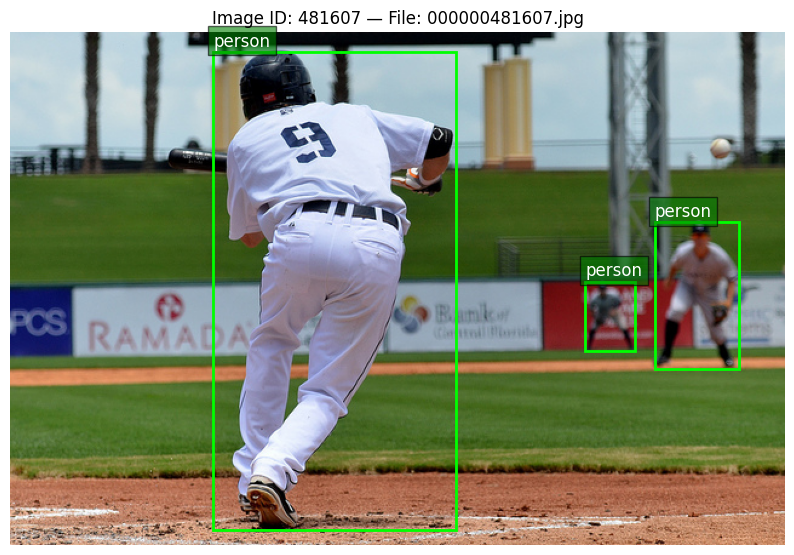

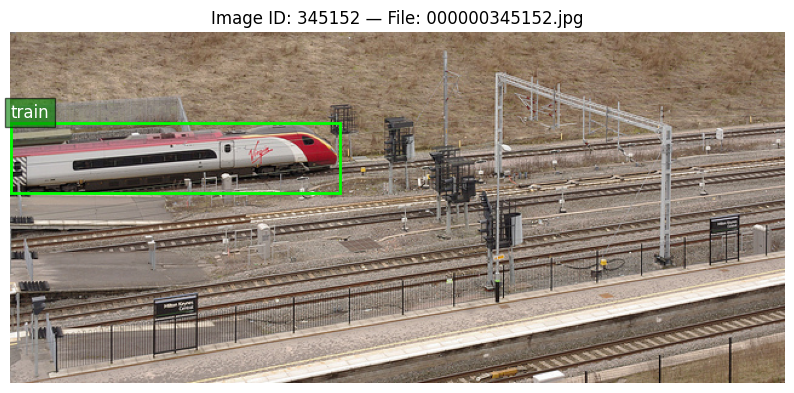

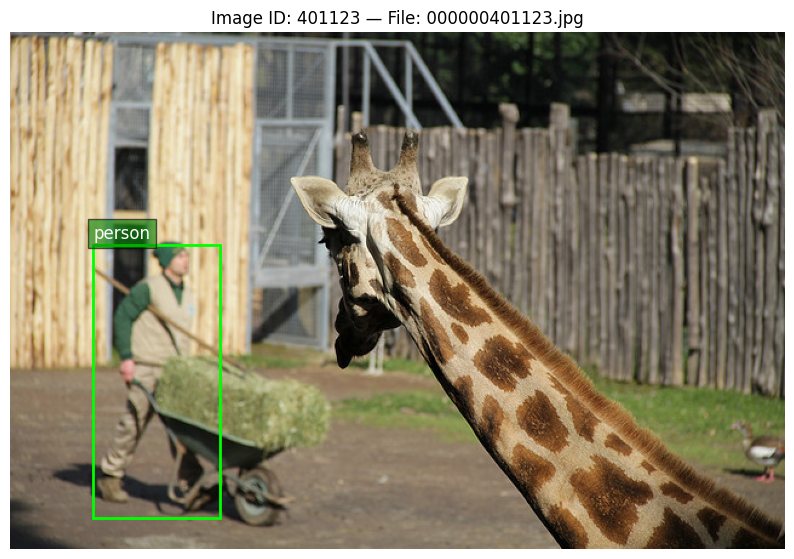

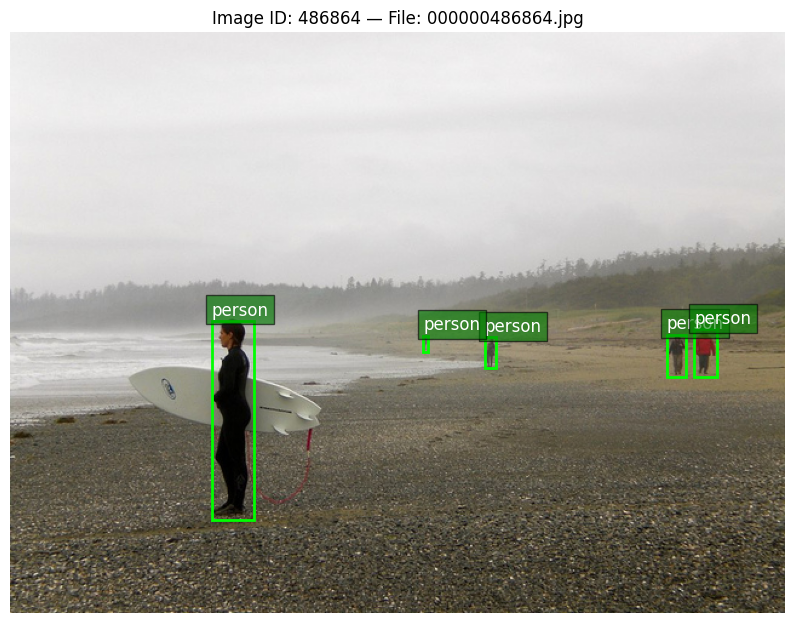

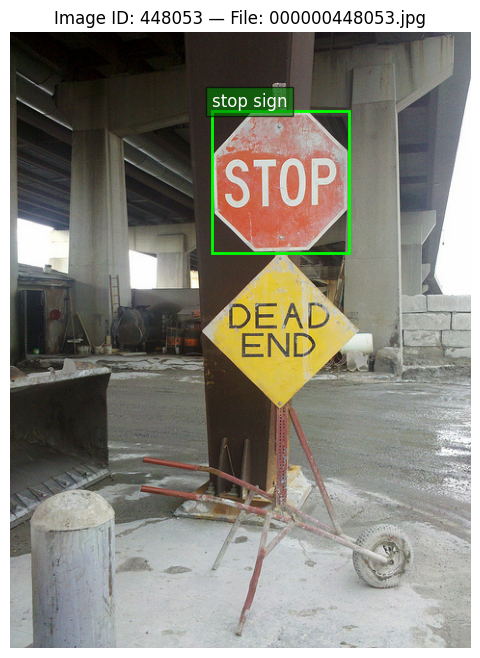

In [ ]:
import os
import random
import cv2
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

img_folder, annotations_file, instance_file = get_path("train")
subset_annotations = '/content/coco_subset/annotations/instances_train2017.json'

# Set paths
image_dir = img_folder
annotation_path = subset_annotations

# Load COCO annotations
with open(annotation_path, "r") as f:
    coco = json.load(f)

# Map image_id to file
image_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
# Map category_id to name
category_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Group annotations by image_id
from collections import defaultdict
image_id_to_anns = defaultdict(list)
for ann in coco["annotations"]:
    image_id_to_anns[ann["image_id"]].append(ann)

# Choose a few random image IDs to visualize
sample_image_ids = random.sample(list(image_id_to_anns.keys()), 5)

# Visualize
for img_id in sample_image_ids:
    file_name = image_id_to_filename[img_id]
    anns = image_id_to_anns[img_id]

    img_path = os.path.join(image_dir, file_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for ann in anns:
        bbox = ann["bbox"]  # [x, y, width, height]
        x, y, w, h = bbox
        label = category_id_to_name[ann["category_id"]]
        ax.add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'))
        ax.text(x, y - 5, label, color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.6))

    plt.axis('off')
    plt.title(f"Image ID: {img_id} — File: {file_name}")
    plt.show()


In [ ]:

img_folder, annotations_file, instance_file = get_path("train")
subset_annotations = '/content/coco_subset/annotations/instances_train2017.json'

IMG_DIR = img_folder
ANN_PATH = subset_annotations
CLASS_IDs = keep_classes

def sample_image_ids(coco_obj, class_ids, samples_per_class=500):
  sampled_ids = set()
  for cid in class_ids:
      img_ids = coco_obj.getImgIds(catIds=cid)
      sampled = random.sample(img_ids, min(len(img_ids), samples_per_class))
      sampled_ids.update(sampled)
  print(f"Total unique sampled image IDs: {len(sampled_ids)}")
  return list(sampled_ids)

class COCODetection(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_path, class_ids, transform, img_ids, samples_per_class=500):
      self.coco = COCO(ann_path)
      self.img_dir = img_dir
      self.transform = transform
      self.class_ids = class_ids
      self.img_ids = img_ids


    def __len__(self):
      return len(self.img_ids)

    def __getitem__(self, idx):
      while True:
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.class_ids)
        anns = self.coco.loadAnns(ann_ids)

        image_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, image_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))

        bboxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        if len(bboxes) == 0:
            idx = (idx + 1) % len(self.img_ids)
            continue

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=labels)
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['category_ids']

        boxes = torch.tensor([[x, y, x + w, y + h] for x, y, w, h in bboxes], dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([img_id])}

        return image, target

# Collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
import random
# Load COCO annotations
coco_obj = COCO(ANN_PATH)

# Sample ~500 per class (shared across all augmentations)
shared_img_ids = sample_image_ids(coco_obj, CLASS_IDs, samples_per_class=500)

loading annotations into memory...
Done (t=7.99s)
creating index...
index created!
Total unique sampled image IDs: 4278


In [ ]:
val_img_folder, val_annotations_file, val_instance_file = get_path("valid")
van_subset_annotations = '/content/coco_subset/annotations/instances_val2017.json'

# Load COCO val annotations
coco_val = COCO(van_subset_annotations)

# Sample validation image ids similar to training (optional)
shared_val_img_ids = sample_image_ids(coco_val, CLASS_IDs, samples_per_class=100)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Total unique sampled image IDs: 715


In [ ]:
import shutil
from pathlib import Path

def extract_filenames(coco_obj, image_ids):
    return [coco_obj.loadImgs(img_id)[0]['file_name'] for img_id in image_ids]

train_image_files = extract_filenames(coco_obj, shared_img_ids)
val_image_files = extract_filenames(coco_val, shared_val_img_ids)

new_train_dir = '/content/coco_subset/images/train2017/'
new_val_dir = '/content/coco_subset/images/val2017/'
Path(new_train_dir).mkdir(parents=True, exist_ok=True)
Path(new_val_dir).mkdir(parents=True, exist_ok=True)

# Copy training images
for fname in train_image_files:
    shutil.copy(f"/content/cocoapi/images/train2017/{fname}", f"{new_train_dir}/{fname}")

# Copy validation images
for fname in val_image_files:
    shutil.copy(f"/content/cocoapi/images/val2017/{fname}", f"{new_val_dir}/{fname}")

shutil.rmtree('/content/cocoapi/images/train2017/')
shutil.rmtree('/content/cocoapi/images/val2017/')

In [ ]:
import shutil

# Zip the folder (e.g., /content/coco_subset -> /content/coco_subset.zip)
shutil.make_archive("/content/coco_subset", 'zip', "/content/coco_subset")

from google.colab import files

# Download the zipped folder
files.download("/content/coco_subset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>